## Sentinel-2 and Landsat optical data segmentation

This code uses machine learning, through an unsupervised classification model called K-Means clustering (here is a short description https://www.youtube.com/watch?v=4b5d3muPQmA) to classify different surface conditions / land cover types without the need for training data. Classification is based upon the variance within the data in your region of interest. 

K-Means is one of the most used algorithms in clustering for its simplicity. It basically divides n observations (pixels values in our case) into k clusters (number of classes predefined by user) where each observation belongs to the cluster with the nearest mean. 

The code is designed to work with Sentinel-2 and Landsat data. Using Planetary Computer environments, EO data is sourced from the STAC catalogue and processed in the cloud. 

It is designed to be fairly intuitive, and requires only a few inputs to make it work - these are highlighted in the comments. 


### Import libraries and define functions

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

import stackstac
import planetary_computer
import pystac_client

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable

import xrspatial.multispectral as ms
from xrspatial.convolution import calc_cellsize, circle_kernel, convolution_2d
from xrspatial.focal import mean, focal_stats, hotspots
from xrspatial.multispectral import true_color

from odc.stac import stac_load, configure_rio

from dask.distributed import Client, progress

# For unsupervised classifiaction
import rasterio as rio
import rioxarray
from rasterio.plot import show
from sklearn import cluster
from sklearn.decomposition import PCA

from shapely.geometry import Polygon

import numpy as np

from PIL import Image


#### Function - Convert data to 1D array 

Arguments: Data = image,  dBands = band names to be used
- Create an empty array using our image size, count of bands and data type.
- Loop through bands to fill empty array
- Flatten array into 1D array

In [2]:
def emptyArr (data, dBands):
    # create an empty array with same dimension and data type
    imgxyb = np.empty((len(data.y), len(data.x), len(dBands)),np.dtype(data[dBands[0]].to_numpy()[0][0]))

    # loop through the raster's bands to fill the empty array
    for band in range(imgxyb.shape[2]):
        imgxyb[:,:,band] = data[dBands[band]].to_numpy() 

    # convert to 1d array
    img1d=imgxyb[:,:,:len(dBands)].reshape((imgxyb.shape[0]*imgxyb.shape[1],imgxyb.shape[2]))
    
    return img1d

#### Function - Principle Componenet Analysis

Arguments: data = image, dBands = band names to be analysed, nComp = number of components to produce
- Take the 1D array and fit a PCA model to the data
- Reshape data into a 2D band image
- Add band to image for visulaisation

In [3]:
def pcaFunc (data, dBands, nComp):
    # Create empty array
    img1d = emptyArr (data, dBands)

    pca = PCA(n_components=nComp)
    pca.fit(img1d)
    
    # print("Relative variance in principal components:", pca.explained_variance_ratio_)

    predict = pca.transform(img1d)
    predict_reshape = predict.reshape((len(data.y), len(data.x),nComp))
    
    for x in range(nComp):
        predicxr = xr.DataArray(predict_reshape[:,:,x], coords=data.coords, dims=data.dims, attrs=data.attrs)

        data[f'pca{x}'] = predicxr

#### Function - Segmentation analysis - K-Means Clustering (model)

Arguments: data = image, dBands = band names to be analysed, nClus = number of clusters to be classified, cl_model = empty dictionary to store trained model, db = empty dictionary to store pixel count per class, iDate = year of image to be analysed
- Take 1d array of image with selected bands for analysis
- Perform k-means clustering to train model
- Produce a 2D band of classified data and add to image. 
- Count number of pixels per class

In [4]:
def kmcFunc (data, dBands, nClus, cl_model, db, iDate):
    # Create empty array
    img1d = emptyArr (data, dBands)
    
    cl = cluster.KMeans(n_clusters=nClus) # create an object of the classifier
    param = cl.fit(img1d) # train it
    img_cl = cl.labels_ # get the labels of the classes
    
    # reshape the 1d array predictions to x-y-bands shape order (only one band)
    img_cl = img_cl.reshape(len(data.y), len(data.x))
    data['kmc'] = xr.DataArray(img_cl, coords=data.coords, dims=data.dims, attrs=data.attrs)
    
    cl_model[f'kmc_mod_{iDate}'] = cl
    (unique, counts) = np.unique(data.kmc, return_counts=True)
    db[f'{iDate}'] =  counts

#### Function - Segmentation analysis - K-Means Clustering (prediction)

Arguments: data = image, dBands = band names to be analysed, nClus = number of clusters to be classified, model = trained model, db = empty dictionary to store pixel count per class, iDate = year of image to be analysed
- Take 1d array of image with selected bands for analysis
- Use K-Means model to predict land cover classes
- Produce a 2D band of classified data and add to image. 
- Count number of pixels per class

In [5]:
def kmcPred (data, dBands,nClus, model, db, iDate):
    # Create empty array
    img1d = emptyArr (data, dBands)
    # img1d = np.array(img1d, dtype=np.double)
    # Select Kmc Model
    cl = model
    # predict the clusters in the image 
    pred = cl.predict(img1d)
    # reshape the 1d array predictions to x-y-bands shape order (only one band)
    img_cl = pred
    img_cl = img_cl.reshape(len(data.y), len(data.x))
    
    data['kmc_pred'] = xr.DataArray(img_cl, coords=data.coords, dims=data.dims, attrs=data.attrs)
    
    arr = data.kmc_pred.to_numpy()
    # (unique, counts) = np.unique(data.kmc_pred, return_counts=True)
    
    db[f'{iDate}'] =  [(arr == iClass).sum() for iClass in range(nClus)] 

#### Function - Colour ramp and RGB Plotting functions

In [6]:
# Plot with colourbar  
# Arguments: axis = subplot axis, plot = image to be plotted, minim = minimum pixel value, maxim = maximum pixel value,
#            colors = matplotlib colour bar name, cBar = produce colour bar (True or False)
def pltCbar (axis, plot, minim, maxim, colors, cBar):#,title):  
    im = axis.imshow(plot, vmin = minim, vmax = maxim, cmap = colors)  
    if cBar == True:
        divider = make_axes_locatable(axis)   
        cax = divider.append_axes('right', size='5%', pad=0.05) 
        fig.colorbar(im, cax=cax, orientation='vertical')  
    #axis.set_title(title, fontsize=16, pad = 10)  
    axis.tick_params(labelcolor="k", labelbottom = False, labelleft=False, bottom=False, left=False)

#Plot mutlispectral image
# Arguments: axis = subplot axis, plot = image to be plotted
def pltRGB (axis, plot):#,title):    
    im = axis.imshow(plot)   
    #axis.set_title(title, fontsize=16, pad = 10)    
    axis.tick_params(labelcolor="k", labelbottom = False, labelleft=False, bottom=False, left=False)
    
def scaleCCC(x):
    return((x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x,2)))

In [7]:
# Plot change detection between first and last image in series
def changeDet (aData, yearLst, clasLst, axis):
    startArr = np.where(aData[f'{yearLst[0]}'].isin(clasLst), 1, 0)
    endArr = np.where(aData[f'{yearLst[-1]}'].isin(clasLst), 1, 0)

    NC_layer = startArr*endArr
    NC_layer = np.where(NC_layer==1,2,0)
    C_layer = (endArr-startArr)+NC_layer
    C_layer = np.where(C_layer == 0, np.nan, C_layer)
    C_layer = np.where(C_layer == 2, 0, C_layer)
    # Plot change 
    pltCbar(axis,C_layer,-1,2, 'plasma', False)

### Gif making function

In [8]:
def make_gif(files, pName):
    # frames = [Image.open(image) for image in glob.glob("*.jpg")]
    frames = [Image.open(image) for image in files]
    frame_one = frames[0]
    frame_one.save(f'{pName}.gif', format="GIF", append_images=frames,
               save_all=True, duration=800, loop=0)


### Inititate client server and access stac catalog

You need to inititate a proxy client server and sign into the planetary computer stac. This will be automatic (no change required), and you only need to run this code once per session.  

In [9]:
client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


In [10]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Load point data

In [11]:
# df = pd.read_csv('Potential_sites_v2.csv')
# df.columns = df.columns.str.lower()

In [12]:
# Convert xy points into geometry data
# gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.lon,df.lat)).set_crs("EPSG:32630")

In [14]:
region = 'Sudan'
# Import tree location point data
gdf = gpd.read_file(f'{region}_points_v1.shp')
gdf = gdf.to_crs(4326)                       # Define spatial reference system (crs)
gdf.columns = gdf.columns.str.lower()             # format column headings to lowercase
gdf = gdf.loc[gdf.geometry != None]               # remove all tree with no x,y geometry
gdf['id'] = [x for x in range(1, len(gdf)+1)]

pixSize = {'Sudan':(9,9), 'Niger':(9.8,9.8)}

In [15]:
# gdf.to_file(filename=f'{region}_points_v1.shp', driver="ESRI Shapefile")

### Search STAC catologue for EO data

Set search paramaeters for EO data, including co-ordinates of your region of interest ([xmin, ymin, xmax, ymax]) and the years you want to observe. Date search includes data from the 1st Jan of the first year to the 1st Jan in the end year. E.g., start data 2018 / end data 2023, will give you data for 2018 - 2022. 

Set collections argument in the search catalog to change from Sentinel-2 to Landsat data (comment out as required).

In [230]:
eoData = 's2'

eoDict = {'ls': ["landsat-c2-l2", ["nir08", "red", "green", "blue", "swir16"], (3,4), ["landsat-8", "landsat-9"]],
          's2': ["sentinel-2-l2a", ['red','nir', 'B11', 'B12','green', 'blue'], (3,4), ["Sentinel-2A","Sentinel-2B"]]}

# Define which site location you are working in
point = 7

# Extract geomtry from site location file
lat, lon  = round(gdf.geometry.y[point-1], 4), round(gdf.geometry.x[point-1], 4)
# lat, lon  = gdf.lat[point-1], gdf.lon[point-1]
# lat, lon  = 21.725, 11.572

# Define size of roi box around site location point
roi_Xbuff = 0.01
roi_Ybuff = 0.01

# Set a bounding box --- [xmin, ymin, xmax, ymax] in latitude and longitude
bbox = [lon-roi_Xbuff, lat-roi_Ybuff, lon+roi_Xbuff, lat+roi_Ybuff]

# Set a start and end date
start_date = "2011"
end_date = "2023"

start_month = "1"
end_month = "3"

iYears = [x for x in np.arange(int(start_date),int(end_date)+1,1)]
pathName = f'{region}//Site{point}//{region}_{point}_{eoData}_{iYears[0]}-{iYears[-1]}_yearly_{start_month}-{end_month}_data'

gdf.loc[point-1]

id                                                     7
lat                                              14.3108
lon                                              27.2374
geometry    POINT (27.23740175801485 14.310751597079769)
Name: 6, dtype: object

In [231]:
count = 0
for year in iYears:
    search_i = catalog.search(
        # == Choose which data to search for == 
        
        # collections=["sentinel-2-l2a"],
        collections=[eoDict[eoData][0]],
        bbox=bbox,
        # intersects=bbox,
        # datetime=time_of_interest,#
        datetime=f"{year}-{start_month}-01/{year}-{end_month}-01",
        query={"eo:cloud_cover": {"lt": 10},
              "platform": {"in": eoDict[eoData][3]}
              } ,
    )
    if count == 0:
        items = search_i.item_collection()
    else:
        items = items + search_i.item_collection()
        
    count+=1
len(items)>0

True

### Load data from STAC

Load identified data using stac_load() argument. remember to change the bands argument to represent the different bands used with Sentinel-2 or Landsat data (comment out as required). 

Use the ds.persist() argument to persist the data once loaded, this will speed up processing. 

In [232]:
crs = "EPSG:32630"
resolution = 10

ds = stac_load(
    items,
    bands = [x for x in eoDict[eoData][1]],
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    bbox=bbox,
)

# View the Xarray Dataset
print(len(ds.time))
ds

305


<xarray.Dataset>
Dimensions:      (y: 287, x: 282, time: 305)
Coordinates:
  * y            (y) float64 1.822e+06 1.822e+06 ... 1.819e+06 1.819e+06
  * x            (x) float64 3.901e+06 3.901e+06 ... 3.904e+06 3.904e+06
    spatial_ref  int32 32630
  * time         (time) datetime64[ns] 2015-11-21T08:32:42.031000 ... 2023-03...
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 287, 282), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 287, 282), meta=np.ndarray>
    B11          (time, y, x) float32 dask.array<chunksize=(1, 287, 282), meta=np.ndarray>
    B12          (time, y, x) float32 dask.array<chunksize=(1, 287, 282), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 287, 282), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 287, 282), meta=np.ndarray>

In [233]:
ds = ds.persist()

In [234]:
# ds.time

### Yearly median data

Convert data series into annual median composites, before normalising each band with the mean and standard deveiation. 

Median removes erroneous pixel values due to cloud or dust in the atmosphere. 

You can select specific months in the year to use, if certain periods are constantly cloudy/too much vegetaion by using the first code block changing the (>) or (<) values to right months, or simply use (==) specific month if you only want one month. 

In [235]:
# Group data by years and convert to single image from median pixel values
yearly = ds.groupby("time.year").median().compute()

### Define bands for PCA analysis

It is possible to use K-Means clustering with multi-dimensional (muti-spectal/band) data, i.e., you can use all of the bands to identify common multispectral signatures to perform calssification. However, where surface properties produce opposing reflectance regimes in different bands, the accuracy of your classification can be reduced.

Therefore, high dimensional data are often transformed into lower dimensional data via the principal component analysis (PCA), where coherent patterns are defined by the bands with the largest variances.

Principal components are a series of linear combinations of the original variables, among which the first principal component accounts for the greatest variance within a dataset. Each subsequent principal component accounts for the next greatest possible variance and is uncorrelated with the previously defined components.

Here, PCA are described as a single 2D band of continuous values, from which we can perform the K-means classification.

In [236]:
# Define which bands to use to perform the PCA, by default all bands are selected below.
xBands = eoDict[eoData][1]              

In [237]:
# Normalise band values
for band in xBands:
    yearly[f'{band}_norm'] = ((yearly[band] - yearly[band].mean()) / yearly[band].std())
# List normalised band names
xBands = [f'{x}_norm' for x in xBands]

In [238]:
yearly.year

<xarray.DataArray 'year' (year: 9)>
array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])
Coordinates:
    spatial_ref  int32 32630
  * year         (year) int64 2015 2016 2017 2018 2019 2020 2021 2022 2023

### RGB images

Visualise the area of interest as either a true colour RGB composite, or as a combination of false colour composites (FCC) - using the annual median data. Change the rgb argument to either TC = True Colour, or FCC1, or FCC2 = combination of SWIR, NIR and visible bands (Sentinel 2 only).  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


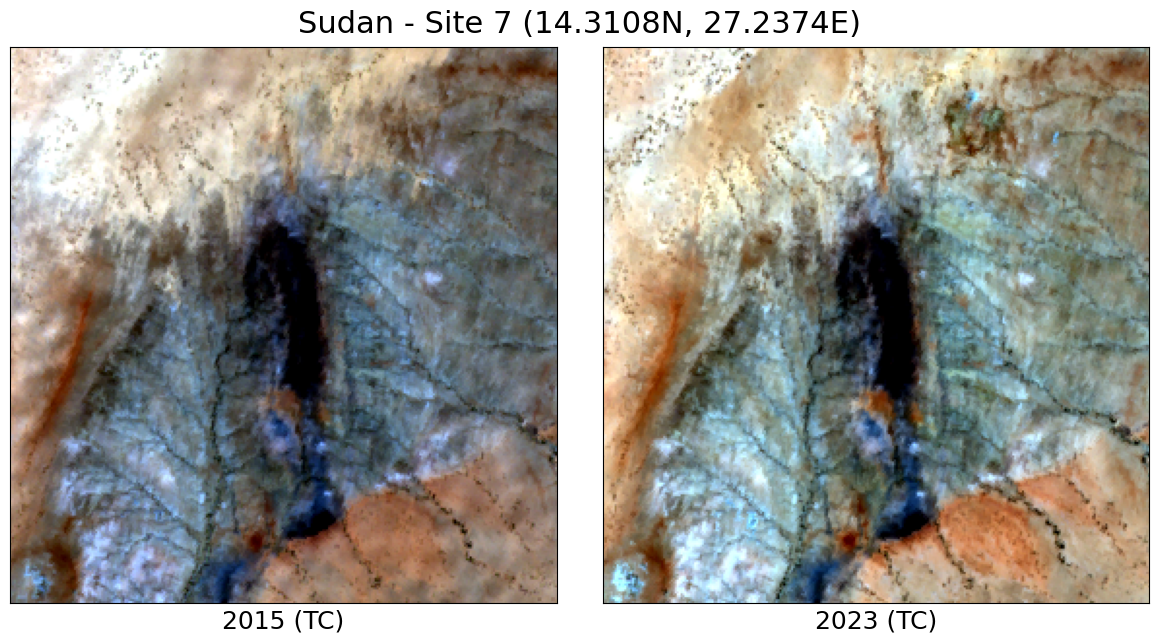

In [239]:
# List of years observed
pYears = [2015,2023]

# Dictionary of potention rgb composites
BandDct = {'TC' : ['red', 'green', 'blue'], 
           'FCC1' : ['B12', 'nir', 'green'],
           'FCC2' : ['B11', 'red', 'B12'] }

# Define which rgb composition to use 
rgb = 'TC'

# Define subplot shape (height, width)
plotShape = (1, 2)
# Define plot size
fig, ax = plt.subplots(figsize=(6*2,6*1))
# Start loop count
count = 0

# Loop through columns and rows of subplots
for x in range(plotShape[0]):
    for y in range(plotShape[1]):
        if count+1 > len(pYears):    # skip loop when no more years to display
            continue
        
        # Subplot description
        ax    = plt.subplot2grid((plotShape), (x, y), colspan=1, rowspan=1) 
        ax.axes.yaxis.set_visible(False)
        
        # Image date selection
        year = count
        yImg  = yearly.sel(year=pYears[year])
        
        # Build rgb image
        rgbCCC    = []
        mbImage = []
        for band in BandDct[rgb]:
            # use 98% contrast stretch (scallCCC)
            mbImage.append(scaleCCC(yImg[band]))
            # Add processed image to list of all rgb date sequence
        rgbCCC.append(np.dstack((mbImage)))

        # Describe image title
        title = f'{pYears[year]} ({rgb})'
    
        # Generate rgb image        
        pltRGB(ax, rgbCCC[0])
        
        # Set subplot title
        ax.set_xlabel(title,fontsize=18)
        
        ax.set_xticks([])
        ax.set_yticks([])
                
        count += 1
        
textstr = f'{region} - Site {point} ({lat}N, {lon}E)'
plt.gcf().text(0.5, 1, textstr, fontsize=22, ha='center')
plt.tight_layout()

### Train model

Using the K-Means clustering analysis to classify the PCA band for a specific year. This will form the model which we will apply to all other years to track changes in the surface condition. 

In [245]:
# Select training year
tYear = 2023
yImg  = yearly.sel(year=tYear)

# Perform PCA function
pcaFunc(yImg, xBands, 3)

# Define which bands will be used for the K-Means clustering
kbands   = ['pca0']
pixCount = {}         # empty dictionary to store the counts of pixels per land cover class  

# Train K-means segmentation model
cl_mod   = {}
kmcFunc(yImg, kbands, 5, cl_mod, pixCount, tYear)


### Check PCA results

By checking the PCA results, you can determine which band is the best to use to train the K-means segmentation model. Update the Train model code above with the correct pca band (i.e., 'pca0', 'pca1', or 'pca2'). Use the updated model to predict other years in the subsequent code. 

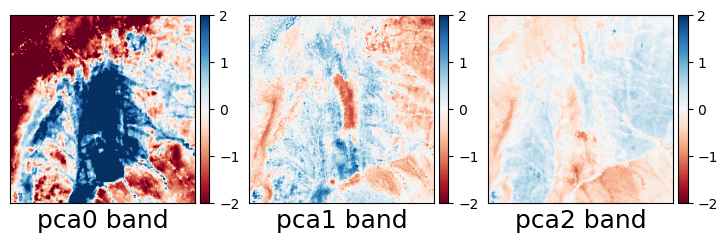

In [241]:
# Define subplot shape (height, width)
plotShape = (1, len(xBands))
# Define plot size
fig, ax = plt.subplots(figsize=(18,12))
# Define plot background colour
fig.patch.set_facecolor('white')

pcaBands = ['pca0','pca1','pca2']

for x in range(0, 3):  
    # Define subplot position and shape
    ax = plt.subplot2grid((plotShape), (0, x), colspan=1, rowspan=1)  
    
    title = f'{pcaBands[x]} band' 
    pltCbar(ax,yImg[pcaBands[x]],-2,2, 'RdBu', True)                
    ax.set_xlabel(f'{title}',fontsize=18) 

### Predict land classes from trained model 

yearly = xr.open_dataset(f'{pathName}.nc').load()Using the trained model, we can predict the land surface classes for all other years. The number of pixels per class will counted so we can determine if there has been a change in the total area of each class between years.  

This code cell can be changed to visualise either the K-means classification, or the PCA analysis. You can also mask specific classes within the K-means calssification for visualisation purposes by selecting the bands you want to show in the classLs variable and comment out the plotting method as necessary.

To export the data to geotiff, uncomment the rio_to_raster line within the loop. This will save each annual median image, with all spectral bands, Pca, and K-means classes to a geotiff in the Planetary computer folder that you saved this code. These data can then be downloaded to be used elsewhere. 

** Caution, make sure you don not use all of your permitted memory by deleteing the files in Planetary Computer once you have successfully downloaded them. **

2015
2016
2017
2018
2019
2020
2021
2022
2023


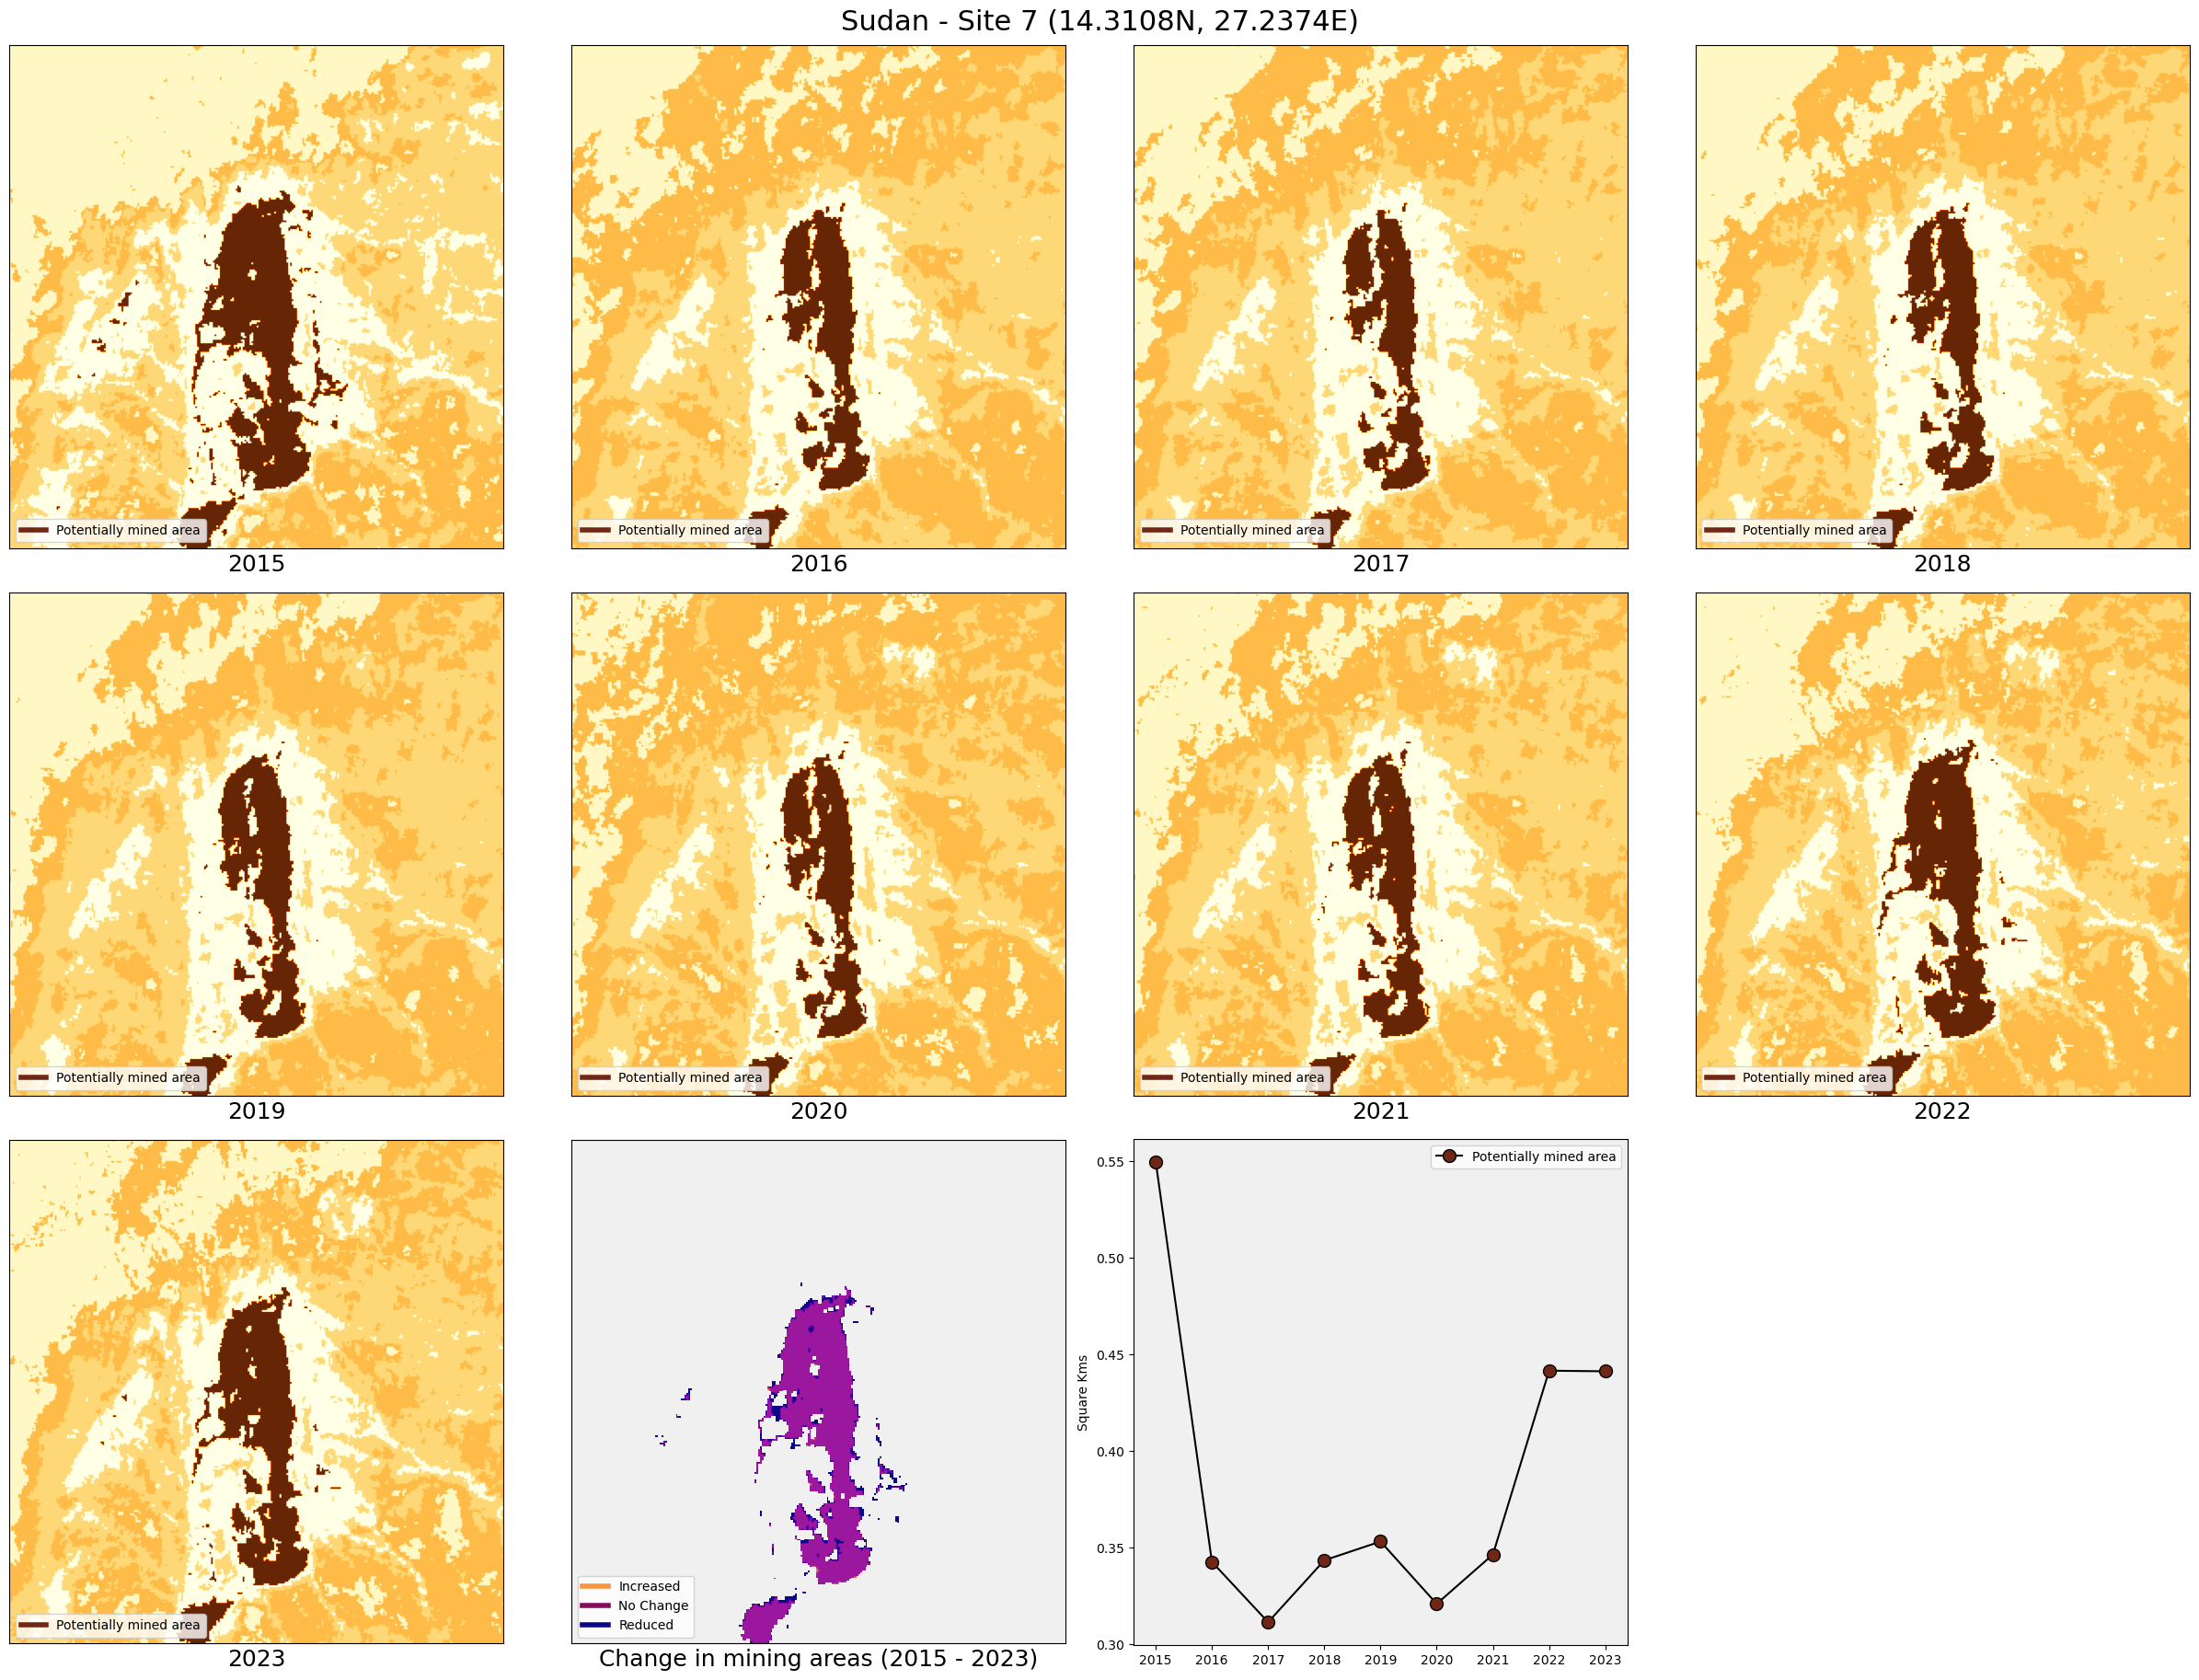

In [247]:
# Inverse specific years if required
invYears  = []

classObs  = False
imgExport = True
loadData  = False

if loadData == True:
    # Load pre-processed data --- Optional ---
    yearly = xr.open_dataset(f'{pathName}.nc').load()
    # Load site dictionay
    siteDict = np.load(f'{pathName}.npy',allow_pickle='TRUE').item()
    # Prevent saving of images 
    imgExport = False
    # Land class(s) to plot
    classLs = siteDict['mClass']
    # Specifiy segmentation model
    kModel = siteDict['model'][list(siteDict['model'].keys())[0]]
    # Define which bands to use to perform the PCA, by default all bands are selected below.
    xBands = eoDict[eoData][1]
    # Define which bands will be used for the K-Means clustering
    kbands   = ['pca0']
else:
    # Land class(s) to plot
    classLs = [2]
    # Specifiy segmentation model
    kModel = cl_mod[f'kmc_mod_{tYear}']

leg2 =  [Line2D([0], [0], color='#f89541', lw=4, label='Increased'),
         Line2D([0], [0], color='#860c5d', lw=4, label='No Change'),
         Line2D([0], [0], color='#0d0887', lw=4, label='Reduced'),]

pixCount = {}         # empty dictionary to store the counts of pixels per land cover class  

iYears    = [x for x in np.arange(int(start_date),int(end_date)+1,1) if x in yearly.year]
# iYears    = iYears[1::]
# Create a list of years. 
dDates = [str(x) for x in iYears]

# Sentinel-2 data
plotS = eoDict[eoData][2]
# Define subplot shape (height, width)
plotShape = plotS
# Define plot size
fig, ax = plt.subplots(figsize=(6*plotS[1],6*plotS[0]))

# Start loop count
count = 0

empty = {}



colDict = {0:['#712716', 'Potentially mined area'], 1:['#F35A17','Potentially mined area (Secondary)']}
colDict2 = {0:'#000004', 1:'#50127b', 2:'#aa005b', 3:'#fb8761', 4: '#fcfdbf'}

for y in range (plotShape[0]):
    # Loop through columns and rows of subplots
    for x in range(plotShape[1]):

        # Subplot description
        ax    = plt.subplot2grid((plotShape), (y,x), colspan=1, rowspan=1) 
        # ax.set_axis_off()
        ax.set_facecolor('#F0F0F0')

        if count == len(iYears):            
            # Create masked start and end image
            changeDet(empty, iYears, classLs,ax)
            
            # Describe image title
            title = f'Change in mining areas ({pYears[0]} - {pYears[-1]})'
            ax.set_xlabel(title,fontsize=18)
            ax.legend(handles=leg2, loc='lower left')
            # Update count
            count += 1
            continue
            
        elif count > len(iYears):   
            pCounts = pd.DataFrame.from_dict(pixCount)
            # ax.plot()
            legCount = 0
            area = ds.dims['x']*ds.dims['y']*(pixSize[region][0]*pixSize[region][1])/1000000
            for x in dDates:
                pCounts[f'{x}'] = area * (pCounts[x] / pCounts[x].sum()) 
            for n in classLs:
                # Plot time series 
                plt.plot(pCounts.loc[n], marker='o', ms = 10, label = colDict[legCount][1], mfc= colDict[legCount][0], mec = 'k', c = 'k')
                legCount+=1

            ax.set_ylabel('Square Kms')
            ax.legend()
            break

        # Image date selection
        year = count 
        print(iYears[year])
        if iYears[year] in yearly.year:
            
            yImg  = yearly.sel(year=iYears[year])
            
            # == Segmentation model ==
            # Generate pca image
            pcaFunc(yImg, xBands, 3)

            if iYears[year] in invYears:
                yImg[f'{kbands[0]}'] =  yImg[f'{kbands[0]}']*-1

            # Predict land cover from segmentation model
            kmcPred (yImg, kbands,5, kModel, pixCount, iYears[year])

            # Plot annual image 
            classLayer = np.where(yImg.kmc_pred == classLs[0], 10, yImg.kmc_pred)
            if len(classLs)==2:
                classLayer = np.where(classLayer == classLs[1], 7, classLayer)     
            
            if classObs == True:
                pltCbar(ax,yImg.kmc_pred ,0, 4, 'magma', False)
                leg = [Line2D([0], [0], color=colDict2[x], lw=4, label=f'Class {x}') for x in range(5)]
            else:
                pltCbar(ax,classLayer ,0, 10, 'YlOrBr', False)                                                    # K-Means segmentation classificaiton (no mask)
                leg =  [Line2D([0], [0], color=colDict[x][0], lw=4, label=colDict[x][1]) for x in range(len(classLs))]
                
            # Describe image title
            title = f'{iYears[year]}'

            ax.set_xlabel(title,fontsize=18)
            # Define plot background colour
            ax.set_facecolor('#F0F0F0')
            ax.legend(handles=leg, loc='lower left')

            # Export image
            # if imgExport == True:
                # yImg.rio.to_raster(f"{region}//Site{point}//Site_{point}_{eoData}_{iYears[year]}_{lat}N_{lon}E_v1.tif")

            # Save each annual image as an array
            empty[f'{iYears[year]}'] = yImg.kmc_pred
        # Update count
        count += 1
# Plot title
textstr = f'{region} - Site {point} ({lat}N, {lon}E)' 
plt.gcf().text(0.5, 1, textstr, fontsize=22, ha='center')      
plt.tight_layout()

siteDict = {'counts':{n:pCounts.loc[n] for n in classLs}, 'mClass': classLs, 'model':cl_mod }
if imgExport == True:
    np.save(f'{pathName}.npy', siteDict) 
    pd.DataFrame(pCounts.T[[x for x in classLs]]).to_csv(f'{pathName}.csv')
    # Save yearly data to netcdf
    yearly.to_netcdf(path=f'{pathName}.nc')

plt.savefig(f'{region}//Site{point}//allyears.png', dpi = 300)


    

### Create annual images for gif

In [248]:
filenamesRGB  = []
filenamesClss = []

for x in range(2):
    count = 0
    for y in iYears:
        fig, ax = plt.subplots(figsize=(6,6))
        if x == 0:
            classLayer = np.where(empty[str(y)] == classLs[0], 10, empty[str(y)])
            if len(classLs)==2:
                classLayer = np.where(classLayer == classLs[1], 7, classLayer)
            # plot the line chart
            plt.imshow(classLayer,vmin=0, vmax=10, cmap='YlOrBr')
            leg =  [Line2D([0], [0], color=colDict[x][0], lw=4, label=colDict[x][1]) for x in range(len(classLs))]
            plt.legend(handles=leg, loc='upper left')
            # create file name and append it to a list
            filename = f'{region}//Site{point}//{count}_Clss.jpg'
            filenamesClss.append(filename)
            
        else:
            yImg  = yearly.sel(year=iYears[count])
            # Build rgb image
            rgbCCC    = []
            mbImage = []
            for band in BandDct[rgb]:
                # use 98% contrast stretch (scallCCC)
                mbImage.append(scaleCCC(yImg[band]))
                # Add processed image to list of all rgb date sequence
            rgbCCC.append(np.dstack((mbImage)))
            # Generate rgb image 
            plt.imshow(rgbCCC[0])
            # create file name and append it to a list
            filename = f'{region}//Site{point}//{count}_Rgb.jpg'
            filenamesRGB.append(filename)
            
        plt.tick_params(labelcolor="k", labelbottom = False, labelleft=False, bottom=False, left=False)
        plt.text(ds.dims['x']-15, 35, f'{y}', fontsize = 12, ha='right', 
             bbox = dict(facecolor = 'white', alpha = 1))

        # save frame
        plt.savefig(filename, dpi=300)
        plt.close()
        count+=1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(267, 35, '2023')

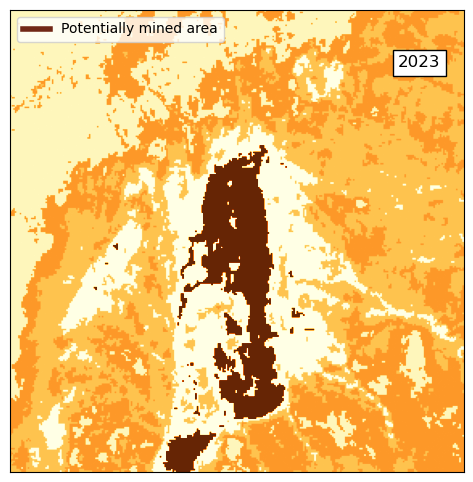

In [249]:
# Create single year image
fig, ax = plt.subplots(figsize=(6,6))
plt.imshow(classLayer,vmin=0, vmax=8, cmap='YlOrBr')
plt.legend(handles=leg, loc='upper left')
plt.tick_params(labelcolor="k", labelbottom = False, labelleft=False, bottom=False, left=False)
plt.text(ds.dims['x']-15, 35, f'{y}', fontsize = 12, ha='right', 
     bbox = dict(facecolor = 'white', alpha = 1))



### Create gif with annual images

In [250]:
make_gif(filenamesRGB, f'{region}//Site{point}//{region}_Site{point}_RGB')
make_gif(filenamesClss, f'{region}//Site{point}//{region}_Site{point}_Clss')

### Final presentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2015
2023


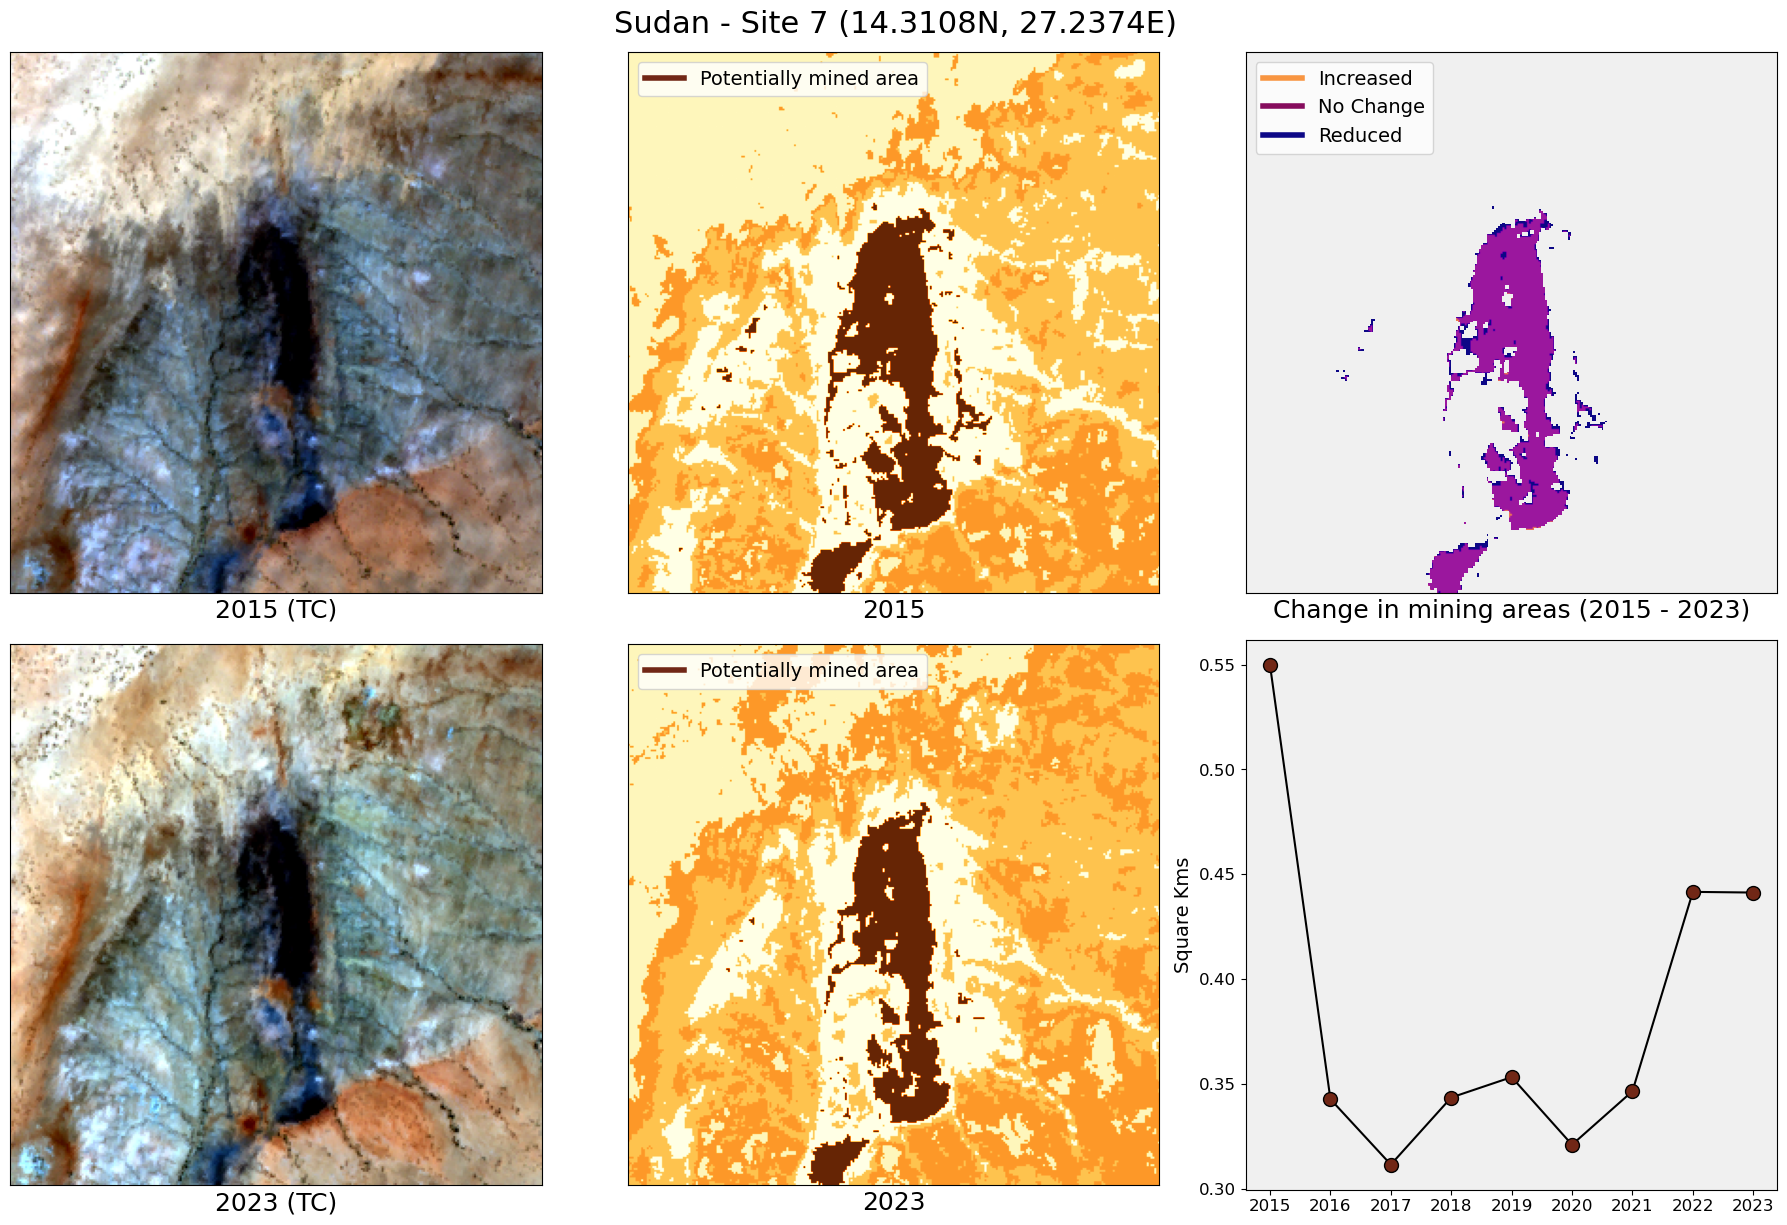

In [251]:
pixCount2 = {}         # empty dictionary to store the counts of pixels per land cover class  
# Create a list of years. 
dDates = [str(x) for x in iYears]

# Define subplot shape (height, width)
plotShape = (2, 3)
# Define plot size
fig, ax = plt.subplots(figsize=(6*3,6*2))
# Start loop count
count = 0

empty = {}

# Land class(s) to plot
classLs = classLs
pYears = [iYears[0], iYears[-1]] 
# Loop through columns and rows of subplots
for x in range(plotShape[1]):
    for y in range(plotShape[0]):

        # Subplot description
        ax    = plt.subplot2grid((plotShape), (y,x), colspan=1, rowspan=1) 
        # ax.set_axis_off()
        ax.set_facecolor('#F0F0F0')
        if x == 2:
            if count == len(pYears)+2:            
                # Create masked start and end image
                changeDet(empty, iYears, classLs,ax)

                # Describe image title
                title = f'Change in mining areas ({pYears[0]} - {pYears[-1]})'
                ax.set_xlabel(title,fontsize=18)
                ax.legend(handles=leg2, fontsize = 14, loc='upper left')
                # Update count
                count += 1
                continue

            elif count > len(pYears):   
                pCounts = pd.DataFrame.from_dict(pixCount)
                # ax.plot()
                legCount = 0
                area = ds.dims['x']*ds.dims['y']*(pixSize[region][0]*pixSize[region][1])/1000000
                for x in dDates:
                    pCounts[f'{x}'] = area * (pCounts[x] / pCounts[x].sum()) 
                for n in classLs:
                    # Plot time series 
                    plt.plot(pCounts.loc[n], marker='o', ms = 10, label = colDict[legCount][1], mfc= colDict[legCount][0], mec = 'k', c = 'k')
                    legCount+=1

                ax.set_ylabel('Square Kms', fontsize = 14)
                # ax.legend(fontsize = 14)
                ax.tick_params(axis='both', which='major', labelsize=12)
                break
        
        
        if x == 0:
            # Image date selection
            year = count      
            yImg  = yearly.sel(year=pYears[year])
        
            # Build rgb image
            rgbCCC    = []
            mbImage = []
            for band in BandDct[rgb]:
                # use 98% contrast stretch (scallCCC)
                mbImage.append(scaleCCC(yImg[band]))
                # Add processed image to list of all rgb date sequence
            rgbCCC.append(np.dstack((mbImage)))

            # Describe image title
            title = f'{pYears[year]} ({rgb})'
            
            ax.set_xlabel(title,fontsize=18)

            # Generate rgb image        
            pltRGB(ax, rgbCCC[0])
            # Update count
            count += 1
        
        if x == 1:            
            # Image date selection
            year = count-2      
            yImg  = yearly.sel(year=pYears[year])

            # == Segmentation model ==
            # Generate pca image
            pcaFunc(yImg, xBands, 3)

            if pYears[year] in invYears:
                
                yImg[f'{kbands[0]}'] =  yImg[f'{kbands[0]}']*-1

            # Predict land cover from segmentation model
            kmcPred (yImg, kbands,5, cl_mod[f'kmc_mod_{tYear}'], pixCount2, iYears[year])

            print(pYears[year])
            
            # Plot annual image 
            classLayer = np.where(yImg.kmc_pred == classLs[0], 8, yImg.kmc_pred)
            if len(classLs)==2:
                classLayer = np.where(classLayer == classLs[1], 6, classLayer)     
            
            pltCbar(ax,classLayer ,0, 8, 'YlOrBr', False)                                                    # K-Means segmentation classificaiton (no mask)
            leg =  [Line2D([0], [0], color=colDict[x][0], lw=4, label=colDict[x][1]) for x in range(len(classLs))]

            # Describe image title
            title = f'{pYears[year]}'

            ax.set_xlabel(title,fontsize=18)
            # Define plot background colour
            ax.set_facecolor('#F0F0F0')
            ax.legend(handles=leg, fontsize = 14, loc='upper left')

            # Save each annual image as an array
            empty[f'{pYears[year]}'] = yImg.kmc_pred
            # Update count
            count += 1
# Plot title
textstr = f'{region} - Site {point} ({lat}N, {lon}E)' 
plt.gcf().text(0.5, 1, textstr, fontsize=22, ha='center')      
plt.tight_layout()

plt.savefig(f'{region}//Site{point}//final_plot.png', dpi = 300)

## Additional Plots

Additionally, you can plot the individual bands (normalised) for a specific year of observed data. 

In [ ]:
# Define subplot shape (height, width)
plotShape = (1, len(xBands))
# Define plot size
fig, ax = plt.subplots(figsize=(18,12))
# Define plot background colour
fig.patch.set_facecolor('white')

# Select year
yImg  = yearly.sel(year=2022)

for x in range(0, len(xBands)):  
    # Define subplot position and shape
    ax = plt.subplot2grid((plotShape), (0, x), colspan=1, rowspan=1)  
    
    title = f'{xBands[x]} band' 
    pltCbar(ax,yImg[xBands[x]],-5,5, 'RdBu', True)                
    ax.set_xlabel(f'{title}',fontsize=18) 

### Monthly mosaics

Visualise the area of interest as monthly median data (from the entire series) either as a true colour RGB composite, or as a combination of false colour composites (FCC). Change the rgb argument to either TC = True Colour, or FCC1, or FCC2 = combination of SWIR, NIR and visible bands (Sentinel 2 only).  

In [85]:
monthly = ds.groupby("time.month").median().compute()

In [86]:
# list bands #### comment out to select between Sentinel-2 and Landsat data ####
xBands = ['red','green','blue','nir', 'B11', 'B12']              # Sentinel-2
# xBands = ['red','green','blue','nir08', 'swir16']              # Landsat

# Normalise band values
for band in xBands:
    monthly[f'{band}_norm'] = ((monthly[band] - monthly[band].mean()) / monthly[band].std())
    
# List normalised band names
xBands = [f'{x}_norm' for x in xBands]

KeyError: "not all values found in index 'month'. Try setting the `method` keyword argument (example: method='nearest')."

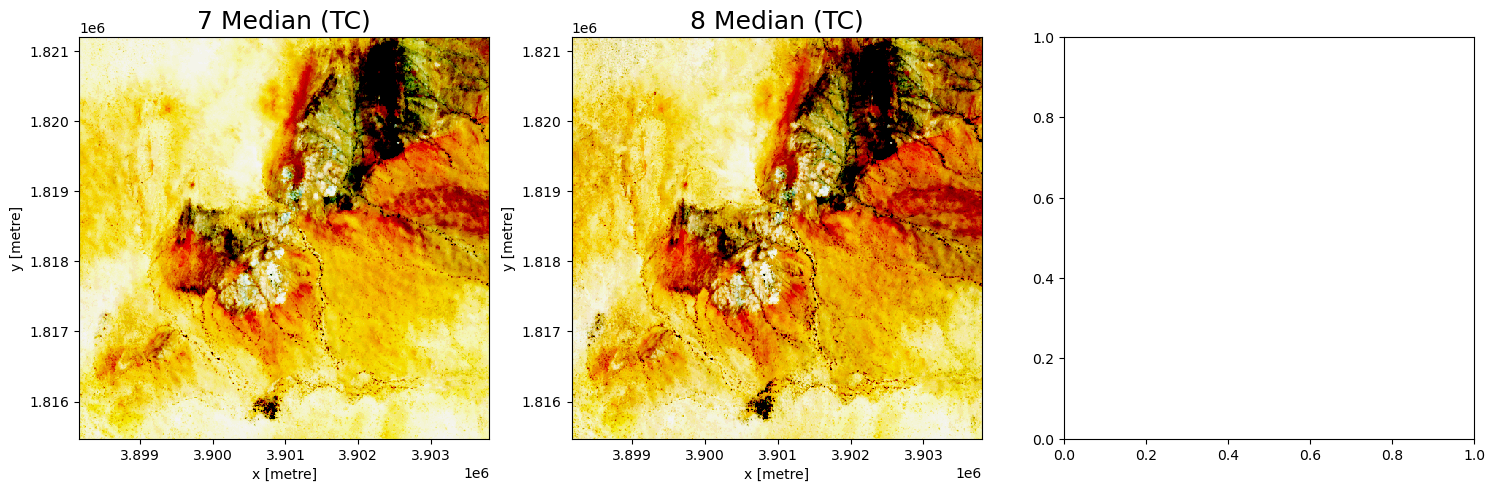

In [90]:
# Dictionary of potention rgb composites
BandDct = {'TC' : ['red', 'green', 'blue'], 
           'FCC1' : ['B12', 'nir', 'green'],
           'FCC2' : ['B11', 'red', 'B12'] } # Sentinel-2 only

# Define which rgb composition to use 
rgb = 'TC'

# Define subplot shape (height, width)
plotShape = (4, 3)
# Define plot size
fig, ax = plt.subplots(figsize=(6*3,6*4))
# Define plot background colour
fig.patch.set_facecolor('white')

iMonth = 7

for x in range(plotShape[0]):
    for y in range(plotShape[1]):
        # Subplot description
        ax    = plt.subplot2grid((plotShape), (x, y), colspan=1, rowspan=1) 
        # ax.set_axis_off()

        # Image date selection
        mImg  = monthly.sel(month=iMonth)
        
        # Select bands for RGB
        red   = mImg[BandDct[rgb][0]]
        green = mImg[BandDct[rgb][1]] 
        blue  = mImg[BandDct[rgb][2]]

        # Describe image title
        title = f'{iMonth} Median ({rgb})'

        # Generate rgb image
        true_color_img = true_color(r=red, g=green, b=blue)
        true_color_img.plot.imshow(ax=ax, vmin=230, vmax=255)
        
        ax.set_title(title,fontsize=18)
        
        iMonth += 1
        
plt.tight_layout()